In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Applications

In [3]:
from pyha.cores import MovingAverage
from pyha.cores.util import *

## Noise removal

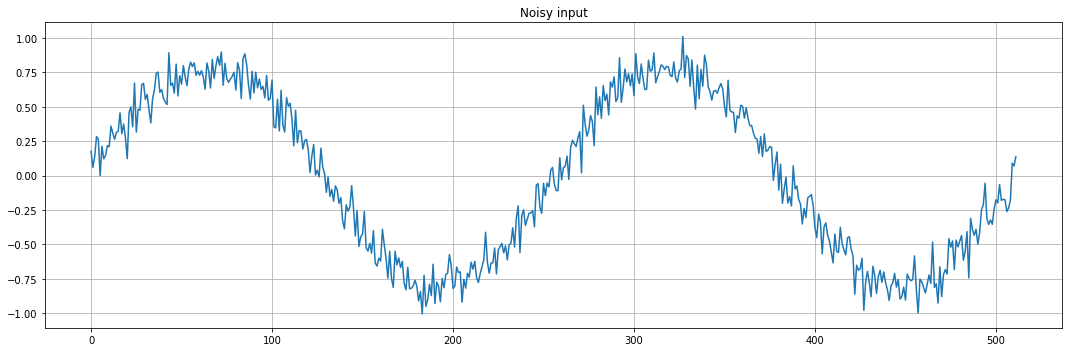

In [4]:
t = np.linspace(0,2*2*np.pi,512)
signal = 0.8*np.sin(t)
noise = 0.1*np.random.normal(size=512)
input_signal = signal +  noise
plt.title('Noisy input')
plt.plot(input_signal)
show_plot()

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 22093.19it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


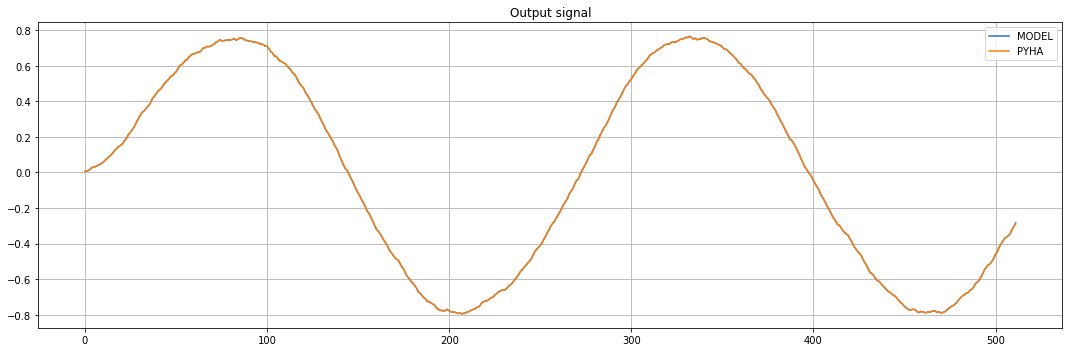

In [6]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

## Low pass filter

In [7]:
# NBVAL_IGNORE_OUTPUT
inp = [0.0] * 512
inp[0] = 1.0
dut = MovingAverage(window_len=32)
sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 36996.47it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [ ]:
plt.title('Frequency domain')
gain_fix = len(inp)
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value) * gain_fix, window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

## Matched filter

In [ ]:
bits = [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
oversample = np.array([[x] * 32 for x in bits]).flatten()
noisy = (oversample + np.random.normal(size=len(oversample))) * 0.25
plt.plot(oversample, label='bits')
plt.plot(noisy, label='input signal (noisy bits)')
show_plot()

In [ ]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
sims = simulate(dut, noisy, simulations=simulations)

In [ ]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

### Example with too small input values

In [ ]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
small_noisy = noisy *  0.0001
sims = simulate(dut, small_noisy, simulations=simulations)

In [ ]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

### Example with too large input values

In [ ]:
# NBVAL_IGNORE_OUTPUT
small_noisy = noisy *  1.5
dut = MovingAverage(window_len=32)
sims = simulate(dut, small_noisy, simulations=simulations)

In [ ]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

### Conclusion
Keep inputs in 1 .. -1 range and expect outputs in 1 .. -1 range.

# Synthesis

In [ ]:
# NBVAL_IGNORE_OUTPUT
output_dir = '/tmp/pyha_output'
dut = MovingAverage(window_len=32)
sims = simulate(dut, signal, simulations=['PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

In [ ]:
assert hardware_sims_equal(sims)

In [ ]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')